# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [1077]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from statsmodels.graphics.tsaplots import plot_acf
import yfinance as yf

In [1078]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    #paths
    paths = S0*np.exp(log_returns)
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    return paths

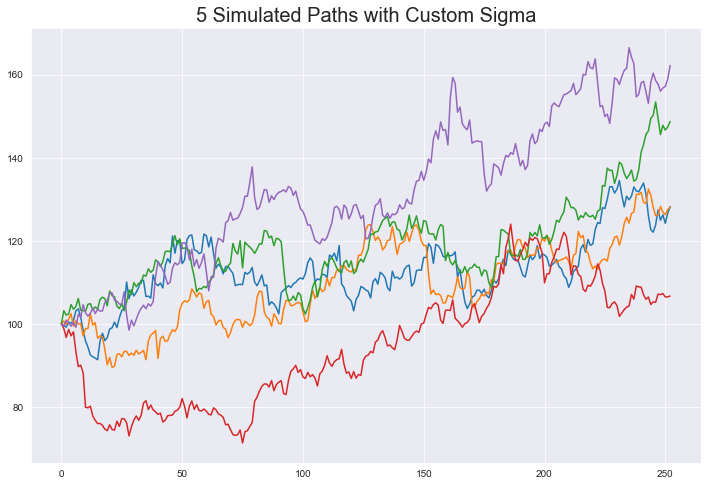

In [1079]:
# Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252

simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)

plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)

plt.show()

# - - - - Mini-Project 4 - - - -

# Paths with constant $\sigma$

In [1080]:
def stock_path_constant_sigma(S0, t, r, mu, sigma, n_paths, n_steps):
    noise = np.random.normal(0, 1, size=(n_paths, n_steps))
    dt = t / n_steps
    increments = (mu + r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * noise
    log_returns = np.cumsum(increments, axis=1)
    paths = S0 * np.exp(log_returns)
    paths = np.insert(paths, 0, S0, axis=1)
    return paths

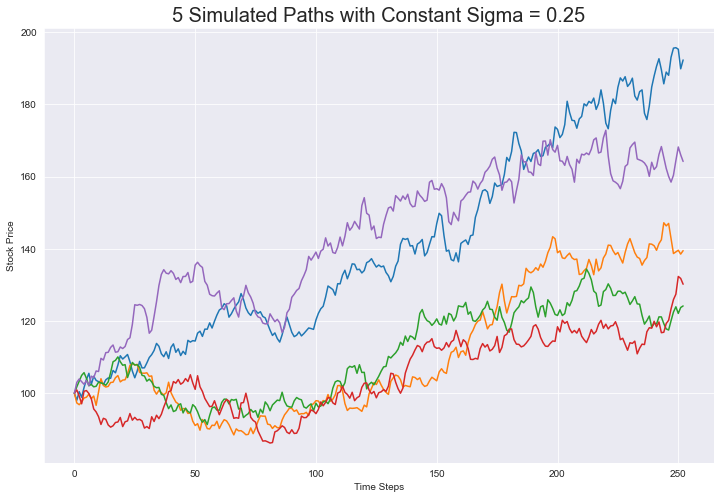

In [1081]:
S0 = 100
t = 1
r = 0.039
mu = 0.275
sigma = 0.25    # constant volatility
n_paths = 5
n_steps = 252

# Simulate paths
simulated_paths_const = stock_path_constant_sigma(S0, t, r, mu, sigma, n_paths, n_steps)

plt.figure(figsize=(12, 8))

for path in simulated_paths_const:
    plt.plot(path)

plt.title(f'{n_paths} Simulated Paths with Constant Sigma = {sigma}', size=20)
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

# GARCH (Generalized Autoregressive Conditional Heteroskedasticity) Model

- The GARCH model is used to model and forecast **time-varying volatility** in financial time series.
- It captures **volatility clustering**, where large changes tend to be followed by large changes, and small changes by small changes.
- The model defines the **conditional variance** at time *t* as a function of:
  - Past squared returns (shocks),
  - Past variances (volatility persistence).
- The simplest GARCH(1,1) model is given by: $\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$

  where:
  - $\sigma_t^2$ is the conditional variance at time *t*,
  - $\epsilon_{t-1}$ is the return shock at time *t-1*,
  - $\omega > 0$, $\alpha \geq 0$, $\beta \geq 0$ are parameters.

https://www.youtube.com/watch?v=P-_3M1LnIa8

In [1082]:
def stock_path_custom_sigma_modified(S0, t, r, mu, n_paths, n_steps):
    '''
    Stock paths with non-constant sigma randomly switching at each step.
    Compared to the above function, this also returns sigma along with the path.
    '''
    dt = t / n_steps

    # Randomly choose sigma for each step with given probabilities
    sigma = np.random.choice([0.2, 0.3, 0.45], size=(n_paths, n_steps), p=[0.5, 0.3, 0.2])
    
    # Noise for increments
    noise = np.random.normal(0, 1, size=(n_paths, n_steps))
    
    # Calculate log returns increments using GBM formula with varying sigma
    increments = (mu + r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * noise
    
    # Cumulative sum of log returns
    log_returns = np.cumsum(increments, axis=1)
    
    # Calculate price paths
    paths = S0 * np.exp(log_returns)
    
    # Insert initial price at the start of each path
    paths = np.insert(paths, 0, S0, axis=1)
    
    return paths, sigma

def garch_volatility(t, omega=0.01, alpha=0.05, beta=0.9, n_steps=252):
    '''
    Generate a volatility path using a simple GARCH(1,1) model.
    '''
    #dt = t / n_steps
    sigma2 = np.zeros(n_steps)
    returns = np.zeros(n_steps)
    
    # Initialize conditional variance with long-run variance
    sigma2[0] = omega / (1 - alpha - beta)
    
    for t in range(1, n_steps):
        returns[t-1] = np.sqrt(sigma2[t-1]) * np.random.normal()
        sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]
    
    sigma = np.sqrt(sigma2)
    return sigma

def stock_path_garch_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Simulate stock paths with volatility generated from GARCH(1,1) model.
    '''
    dt = t / n_steps
    
    paths = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = S0
    
    for i in range(n_paths):
        sigma = garch_volatility(t, n_steps=n_steps)
        noise = np.random.normal(0, 1, n_steps)
        increments = (mu + r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * noise
        log_returns = np.cumsum(increments)
        paths[i, 1:] = S0 * np.exp(log_returns)
    
    return paths

In [1083]:
# Parameters
S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252

# Simulate paths with custom sigma
custom_sigma_paths, custom_sigma = stock_path_custom_sigma_modified(S0, t, r, mu, n_paths, n_steps)

# Simulate paths with GARCH sigma
garch_sigma_paths = stock_path_garch_sigma(S0, t, r, mu, n_paths, n_steps)

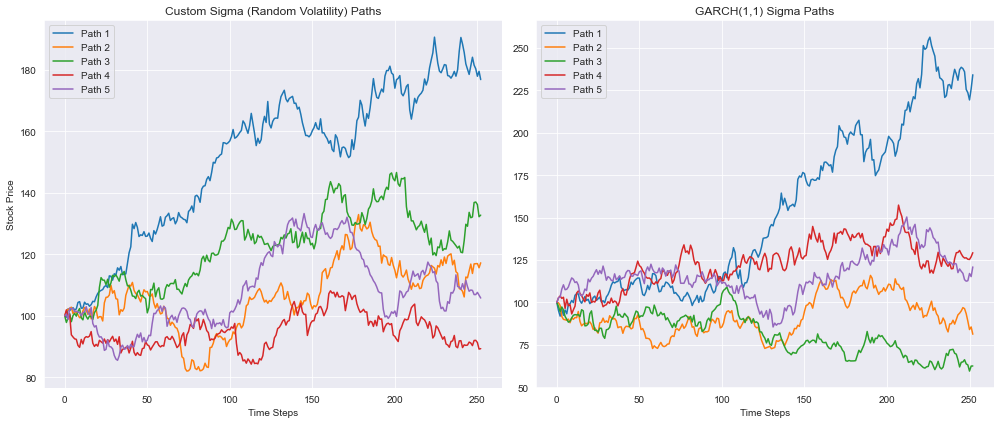

In [1084]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
for i, path in enumerate(custom_sigma_paths):
    plt.plot(path, label=f'Path {i+1}')
plt.title('Custom Sigma (Random Volatility) Paths')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(1, 2, 2)
for i, path in enumerate(garch_sigma_paths):
    plt.plot(path, label=f'Path {i+1}')
plt.title('GARCH(1,1) Sigma Paths')
plt.xlabel('Time Steps')
plt.legend()

plt.tight_layout()
plt.show()


# GARCH(p, q) Model

The **GARCH(p, q)** model generalizes the the above simple model GARCH(1,1), by including multiple lags of past squared residuals and past variances: $\sigma_t^2 = \omega + \sum_{i=1}^q \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

where:
- $\sigma_t^2$ is the conditional variance at time *t*,
- $\epsilon_{t-i}^2$ are lagged squared residuals (shocks) from *i* periods ago,
- $\sigma_{t-j}^2$ are lagged conditional variances from *j* periods ago,
- $\omega > 0$, $\alpha_i \geq 0$, $\beta_j \geq 0$ are parameters controlling the model.

This model captures the persistence of volatility over multiple time lags, allowing a more flexible fit to volatility clustering in financial returns.

In [1085]:
def garch_pq_volatility_paths(T, omega, alpha, beta, n_steps, n_paths):
    '''
    Simulate volatility path from GARCH(p,q) model.
    '''
    p = len(beta)
    q = len(alpha)
    max_lag = max(p, q)

    # Initialize array for volatility squared paths
    sigma2_paths = np.zeros((n_paths, n_steps))
    eps_paths = np.zeros((n_paths, n_steps))

    # Initialize unconditional variance for each path
    unconditional_var = omega / (1 - sum(alpha) - sum(beta))
    sigma2_paths[:, :max_lag] = unconditional_var

    # Initialize residuals for initial lags
    eps_paths[:, :max_lag] = np.sqrt(unconditional_var) * np.random.normal(size=(n_paths, max_lag))

    for t in range(max_lag, n_steps):
        # Calculate lagged squared residuals term for all paths
        alpha_terms = np.zeros(n_paths)
        for i in range(q):
            alpha_terms += alpha[i] * eps_paths[:, t - i - 1]**2

        # Calculate lagged variance term for all paths
        beta_terms = np.zeros(n_paths)
        for j in range(p):
            beta_terms += beta[j] * sigma2_paths[:, t - j - 1]

        # Update conditional variance for all paths
        sigma2_paths[:, t] = omega + alpha_terms + beta_terms

        # Generate new residuals for this step
        eps_paths[:, t] = np.sqrt(sigma2_paths[:, t]) * np.random.normal(size=n_paths)

    sigma_paths = np.sqrt(sigma2_paths)
    return sigma_paths

**Note:** Need to be careful with the variables -- for the conditional variance to be defined, we need $1-(\sum\alpha_i+\sum\beta_j)>0$

In [1086]:
t = 1
n_steps = 252
n_paths = 5
omega = 1e-6
alpha = [0.05, 0.03]  # q = 2 lags of squared residuals
beta = [0.9]          # p = 1 lag of variance
'''
alpha = [0.05, 0.03]     # q = 2
beta = [0.4, 0.3, 0.1]   # p = 3
'''
vol_paths = garch_pq_volatility_paths(t, omega, alpha, beta, n_steps, n_paths)


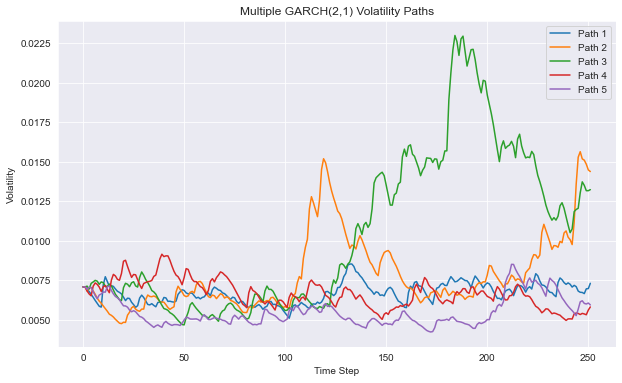

In [1087]:
plt.figure(figsize=(10,6))
for i in range(n_paths):
    plt.plot(vol_paths[i], label=f'Path {i+1}')
plt.title(f'Multiple GARCH({len(alpha)},{len(beta)}) Volatility Paths')
plt.xlabel('Time Step')
plt.ylabel('Volatility')
plt.legend()
plt.show()

### log returns vs. change in variance scatter plot and the correlation coefficient

*Interpretation:*
- $\rho<0$: when stock returns are negative (prices drop), volatility tends to increase (variance goes up). This shows volatility clustering and reactive variance behavior consistent with financial markets.
- $\rho\approx0$: changes in variance are not strongly linked to returns in the simulated paths. This could mean the model’s parameters do not enforce strong feedback from returns to volatility or that noise dominates.
- $\rho>0$ (rare in practice): implies that positive returns lead to higher volatility increases, which and seems to be (in general) inconsistent with market behaviors.

In [1088]:
# Simulate stock paths given vol_paths

dt = t / n_steps
S0 = 100
mu = 0.05  # drift

S_paths = np.zeros((n_paths, n_steps + 1))
S_paths[:, 0] = S0

for i in range(n_paths):
    noise = np.random.normal(size=n_steps)
    for t_idx in range(1, n_steps + 1):
        sigma_t = np.sqrt(vol_paths[i, t_idx - 1])
        dS = (mu - 0.5 * sigma_t**2) * dt + sigma_t * np.sqrt(dt) * noise[t_idx - 1]
        S_paths[i, t_idx] = S_paths[i, t_idx - 1] * np.exp(dS)

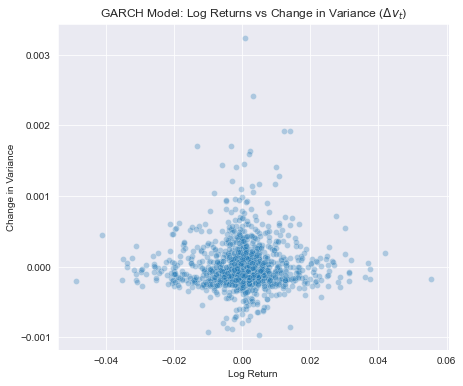

Correlation (GARCH): 0.0068


In [1089]:
# Log returns and volatility changes
vol_changes = vol_paths[:, 1:] - vol_paths[:, :-1]
log_returns = log_returns[:, :vol_changes.shape[1]]  # slice log_returns to match vol_changes length

log_returns_flat = log_returns.flatten()
vol_changes_flat = vol_changes.flatten()


plt.figure(figsize=(7,6))
sns.scatterplot(x=log_returns_flat, y=vol_changes_flat, alpha=0.3)
plt.title("GARCH Model: Log Returns vs Change in Variance ($\\Delta v_t$)")
plt.xlabel("Log Return")
plt.ylabel("Change in Variance")
plt.grid(True)
plt.show()

corr = np.corrcoef(log_returns_flat, vol_changes_flat)[0,1]
print(f"Correlation (GARCH): {corr:.4f}")


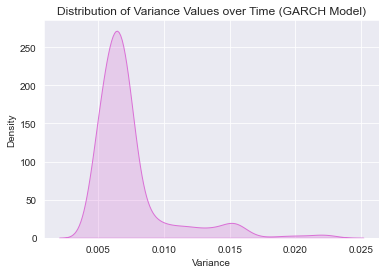

In [1090]:
sns.kdeplot(vol_paths.flatten(), fill=True, color='orchid')
plt.title("Distribution of Variance Values over Time (GARCH Model)")
plt.xlabel("Variance")
plt.ylabel("Density")
plt.grid(True)
plt.show()

# Heston Model

The Heston model describes the evolution of the _volatility_ of an underlying asset. It is a stochastic volatility model -- such a model assumes that the volatility of the asset is not constant, nor even deterministic, but follows a random process -- _the volatility follows a random process_. Furthermore, it is a generalization of the Black-Scholes model.

In [1091]:
def simulate_heston(S0, v0, r, mu, kappa, theta, xi, rho, T, n_steps, n_paths):
    '''
    Simulate stock price paths under the Heston stochastic volatility model.
    
    Parameters:
    -----------
    S0 : Initial stock price
    v0 : Initial variance (volatility^2)
    r  : Risk-free rate
    mu : Drift of the stock
    T  : Total time (in years)
    xi : Volatility of volatility
    rho : Correlation between stock and variance Brownian motions
    kappa : Rate of mean reversion for variance
    theta : Long-term variance level 
    n_steps : Number of time steps
    n_paths : Number of paths to simulate
        
    Returns:
    --------
    S_paths : Simulated stock price paths (n_paths x (n_steps + 1))  -->  ndarray
    v_paths : Simulated variance paths (n_paths x (n_steps + 1))  -->  ndarray
    '''
    dt = T / n_steps
    S_paths = np.zeros((n_paths, n_steps + 1))
    v_paths = np.zeros((n_paths, n_steps + 1))
    
    S_paths[:, 0] = S0
    v_paths[:, 0] = v0
    
    for t in range(1, n_steps + 1):
        # Generate correlated Brownian motions
        Z1 = np.random.normal(size=n_paths)
        Z2 = np.random.normal(size=n_paths)
        dW_v = np.sqrt(dt) * Z1
        dW_s = rho * dW_v + np.sqrt(1 - rho**2) * np.sqrt(dt) * Z2
        
        # Ensure non-negative variance with max(0, v)
        v_prev = v_paths[:, t-1]
        v_paths[:, t] = np.maximum(0, v_prev + kappa * (theta - v_prev) * dt + xi * np.sqrt(v_prev) * dW_v)
        
        S_paths[:, t] = S_paths[:, t-1] * np.exp((mu - 0.5 * v_prev) * dt + np.sqrt(v_prev) * dW_s)
    
    return S_paths, v_paths

In [1092]:
S0 = 100
v0 = 0.04
r = 0.0
mu = 0.05
kappa = 2.0
theta = 0.04
xi = 0.5
rho = -0.7
T = 1
n_steps = 252
n_paths = 5

# Simulate
S_paths, v_paths = simulate_heston(S0, v0, r, mu, kappa, theta, xi, rho, T, n_steps, n_paths)

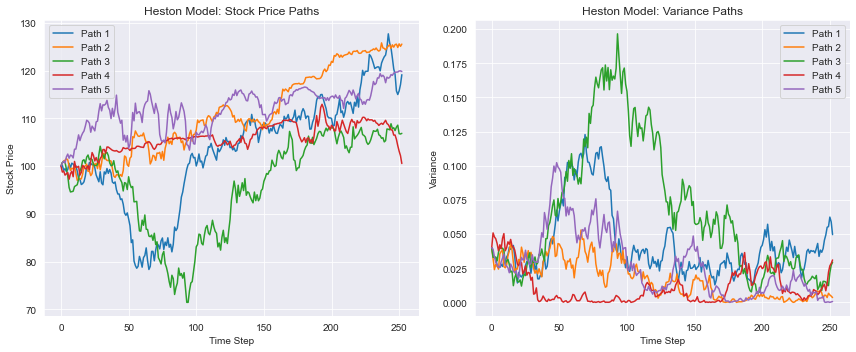

In [1093]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
for i in range(n_paths):
    plt.plot(S_paths[i], label=f'Path {i+1}')
plt.title("Heston Model: Stock Price Paths")
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.legend()

plt.subplot(1, 2, 2)
for i in range(n_paths):
    plt.plot(v_paths[i], label=f'Path {i+1}')
plt.title("Heston Model: Variance Paths")
plt.xlabel("Time Step")
plt.ylabel("Variance")
plt.legend()

plt.tight_layout()
plt.show()


*Interpretation:* the two plots here seem to be representative, of the facts that when volatility spikes/increases, stock price paths often show larger fluctuations.

Furthermore, we observe *mean-reversion*, i.e. the volatility doesn’t just randomly wander forever — -it tends to return over time toward a central, average value, called the long-term mean or long-term volatility level.

In [1094]:
'''
# Use final time step
final_prices = S_paths[:, -1]
final_vols = v_paths[:, -1]

# Or use average over time
avg_prices = np.mean(S_paths[:, 1:], axis=1)
avg_vols = np.mean(v_paths[:, 1:], axis=1)

# Scatter plot: final prices vs final volatility
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=final_prices, y=final_vols)
plt.title('Final Stock Price vs Final Volatility')
plt.xlabel('Final Stock Price')
plt.ylabel('Final Variance')

plt.subplot(1, 2, 2)
sns.scatterplot(x=avg_prices, y=avg_vols)
plt.title('Average Stock Price vs Average Volatility')
plt.xlabel('Average Stock Price')
plt.ylabel('Average Variance')

plt.tight_layout()
plt.show()

# Compute and print correlation
print("Correlation (final):", np.corrcoef(final_prices, final_vols)[0, 1])
print("Correlation (average):", np.corrcoef(avg_prices, avg_vols)[0, 1])
'''

'\n# Use final time step\nfinal_prices = S_paths[:, -1]\nfinal_vols = v_paths[:, -1]\n\n# Or use average over time\navg_prices = np.mean(S_paths[:, 1:], axis=1)\navg_vols = np.mean(v_paths[:, 1:], axis=1)\n\n# Scatter plot: final prices vs final volatility\nplt.figure(figsize=(12, 5))\n\nplt.subplot(1, 2, 1)\nsns.scatterplot(x=final_prices, y=final_vols)\nplt.title(\'Final Stock Price vs Final Volatility\')\nplt.xlabel(\'Final Stock Price\')\nplt.ylabel(\'Final Variance\')\n\nplt.subplot(1, 2, 2)\nsns.scatterplot(x=avg_prices, y=avg_vols)\nplt.title(\'Average Stock Price vs Average Volatility\')\nplt.xlabel(\'Average Stock Price\')\nplt.ylabel(\'Average Variance\')\n\nplt.tight_layout()\nplt.show()\n\n# Compute and print correlation\nprint("Correlation (final):", np.corrcoef(final_prices, final_vols)[0, 1])\nprint("Correlation (average):", np.corrcoef(avg_prices, avg_vols)[0, 1])\n'

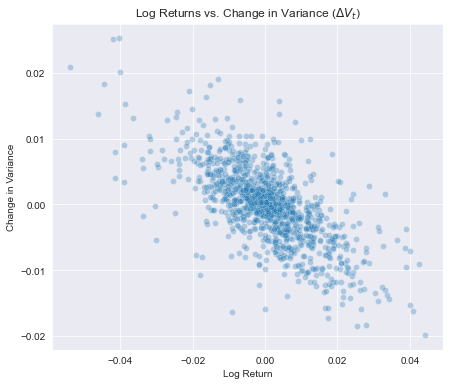

Correlation between log returns and variance change: -0.6822


In [1095]:
# log returns and volatility changes
log_returns = np.log(S_paths[:, 1:] / S_paths[:, :-1])  # shape: (n_paths, n_steps)
vol_changes = v_paths[:, 1:] - v_paths[:, :-1]

log_returns_flat = log_returns.flatten()
vol_changes_flat = vol_changes.flatten()

plt.figure(figsize=(7, 6))
sns.scatterplot(x=log_returns_flat, y=vol_changes_flat, alpha=0.3)
plt.title("Log Returns vs. Change in Variance ($\Delta V_t$)")
plt.xlabel("Log Return")
plt.ylabel("Change in Variance")
plt.grid(True)
plt.show()

corr = np.corrcoef(log_returns_flat, vol_changes_flat)[0, 1]
print(f"Correlation between log returns and variance change: {corr:.4f}")

### Distribution of Final Stock Prices vs Volatility

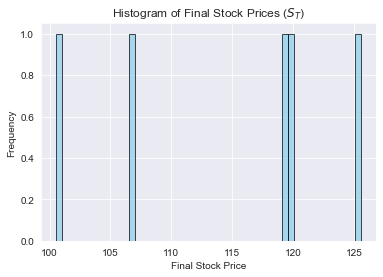

In [1096]:
plt.hist(S_paths[:, -1], bins=50, alpha=0.7, color='skyblue', edgecolor='k')
plt.title("Histogram of Final Stock Prices ($S_T$)")
plt.xlabel("Final Stock Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Distribution of Volatility over Time

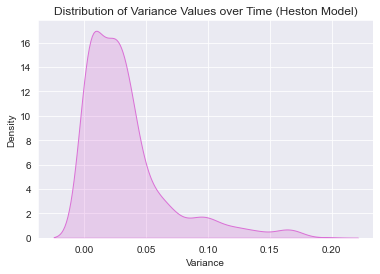

In [1097]:
sns.kdeplot(v_paths.flatten(), fill=True, color='orchid')
plt.title("Distribution of Variance Values over Time (Heston Model)")
plt.xlabel("Variance")
plt.ylabel("Density")
plt.grid(True)
plt.show()

## Time-Series Mean +/- Confidence Interval of Volatility

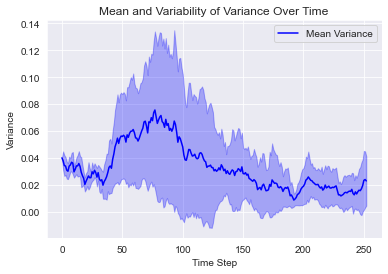

In [1098]:
mean_v = v_paths.mean(axis=0)
std_v = v_paths.std(axis=0)
time = np.arange(v_paths.shape[1])

plt.plot(time, mean_v, label='Mean Variance', color='blue')
plt.fill_between(time, mean_v - std_v, mean_v + std_v, alpha=0.3, color='blue')
plt.title("Mean and Variability of Variance Over Time")
plt.xlabel("Time Step")
plt.ylabel("Variance")
plt.grid(True)
plt.legend()

## Autocorrelation of Variance or Returns

This plot shows the persistence/clustering in volatility. It plots the autocorrelation function (ACF) of $v_t$ or returns.

- The high autocorrelation at low lags indicates that volatility today is highly related to volatility in the recent past.

- The slow decay of the autocorrelation shows volatility clustering —- periods of high or low volatility tend to persist.

<Figure size 720x360 with 0 Axes>

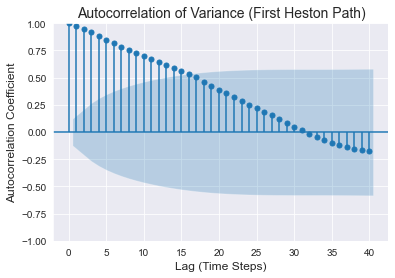

In [1099]:
plt.figure(figsize=(10, 5))
plot_acf(v_paths[0], lags=40)

plt.title("Autocorrelation of Variance (First Heston Path)", fontsize=14)
plt.xlabel("Lag (Time Steps)", fontsize=12)
plt.ylabel("Autocorrelation Coefficient", fontsize=12)
plt.grid(True)
plt.show()

### Autocorrelation of Log Returns 

- Most autocorrelations are near zero, meaning past returns do not help predict future returns.
- This suggests that the stock price process behaves like a random walk in terms of returns.
- It supports the _efficient market hypothesis_, where returns are essentially uncorrelated noise.

<Figure size 720x360 with 0 Axes>

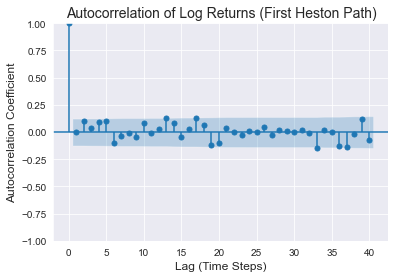

In [1100]:
plt.figure(figsize=(10, 5))
plot_acf(log_returns[0], lags=40, alpha=0.05)

plt.title("Autocorrelation of Log Returns (First Heston Path)", fontsize=14)
plt.xlabel("Lag (Time Steps)", fontsize=12)
plt.ylabel("Autocorrelation Coefficient", fontsize=12)
plt.grid(True)
plt.show()

# Compare the two models to an arbitrary ticker's data

In [1101]:
ticker = "GOOG"
period_var = "6y"
interval_var = "1d"

data = yf.download(ticker, period = period_var, interval = interval_var)
data = data.dropna()

[*********************100%***********************]  1 of 1 completed


In [1102]:
# log returns and realized variance
data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
data['realized_variance'] = data['log_return'].rolling(window=10).var()  # 10-day rolling variance

data = data.dropna()

In [1103]:
# Select sample from GARCH and Heston paths
sample_garch_var = vol_paths[1]  # select a single GARCH path
sample_heston_var = v_paths[1]   # select a single Heston path

# Reduced sampled paths to match length of the real data
n_obs = len(data)
sample_garch_var = sample_garch_var[:n_obs]
sample_heston_var = sample_heston_var[:n_obs]

# Trim real data and simulated paths to same length
n_sim_steps = min(len(sample_garch_var), n_obs)  # need this in case len(sample_garch_var) < n_obs
data_trimmed = data.iloc[:n_sim_steps]
garch_trimmed = sample_garch_var[:n_sim_steps]
heston_trimmed = sample_heston_var[:n_sim_steps]

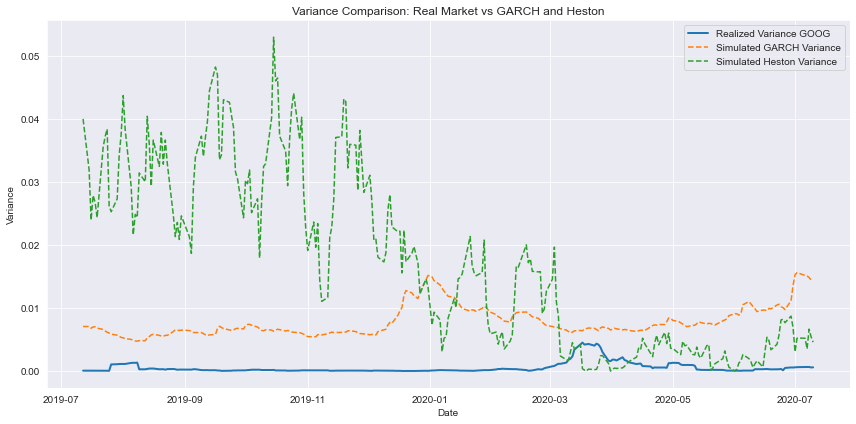

In [1104]:
plt.figure(figsize=(12, 6))
plt.plot(data_trimmed.index, data_trimmed['realized_variance'], label=f'Realized Variance {ticker}', linewidth=2)
plt.plot(data_trimmed.index, garch_trimmed, label='Simulated GARCH Variance', linestyle='--')
plt.plot(data_trimmed.index, heston_trimmed, label='Simulated Heston Variance', linestyle='--')
plt.title("Variance Comparison: Real Market vs GARCH and Heston")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


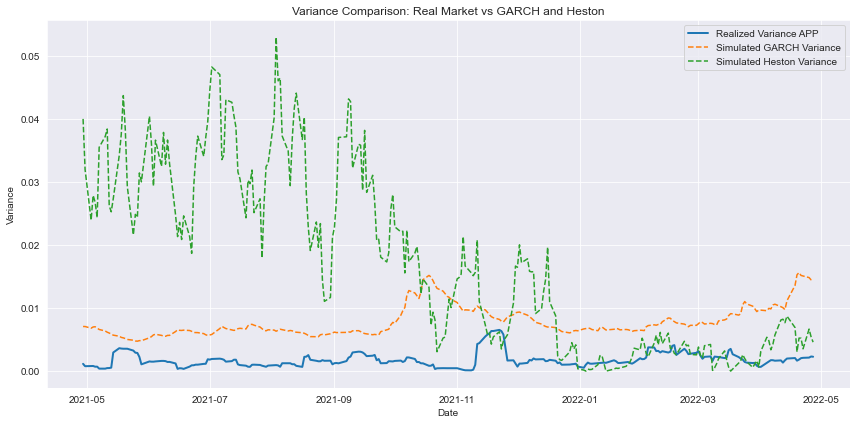

In [1105]:
# Do it for another ticker
ticker = "APP"
data = yf.download(ticker, period = period_var, interval = interval_var)
data = data.dropna()

# log returns and realized variance
data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
data['realized_variance'] = data['log_return'].rolling(window=10).var()  # 10-day rolling variance

data = data.dropna()

# Trim real data and simulated paths to same length
data_trimmed = data.iloc[:n_sim_steps]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(data_trimmed.index, data_trimmed['realized_variance'], label=f'Realized Variance {ticker}', linewidth=2)
plt.plot(data_trimmed.index, garch_trimmed, label='Simulated GARCH Variance', linestyle='--')
plt.plot(data_trimmed.index, heston_trimmed, label='Simulated Heston Variance', linestyle='--')
plt.title("Variance Comparison: Real Market vs GARCH and Heston")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


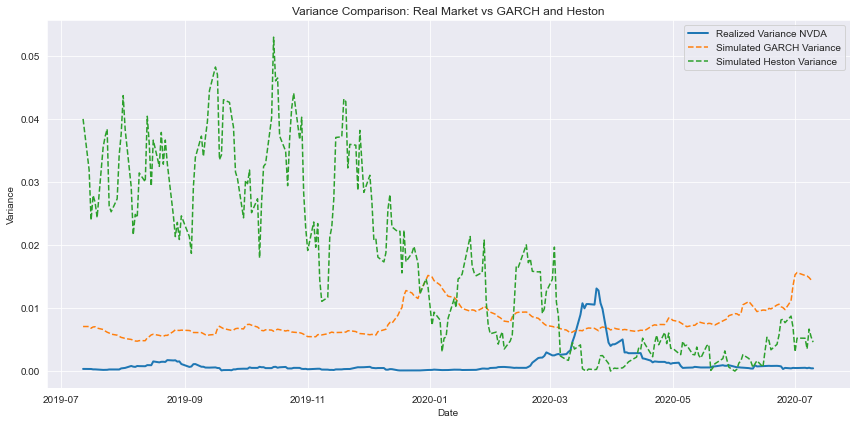

In [1106]:
# Do it for another ticker
ticker = "NVDA"
data = yf.download(ticker, period = period_var, interval = interval_var)
data = data.dropna()

# log returns and realized variance
data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
data['realized_variance'] = data['log_return'].rolling(window=10).var()  # 10-day rolling variance

data = data.dropna()

# Trim real data and simulated paths to same length
data_trimmed = data.iloc[:n_sim_steps]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(data_trimmed.index, data_trimmed['realized_variance'], label=f'Realized Variance {ticker}', linewidth=2)
plt.plot(data_trimmed.index, garch_trimmed, label='Simulated GARCH Variance', linestyle='--')
plt.plot(data_trimmed.index, heston_trimmed, label='Simulated Heston Variance', linestyle='--')
plt.title("Variance Comparison: Real Market vs GARCH and Heston")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


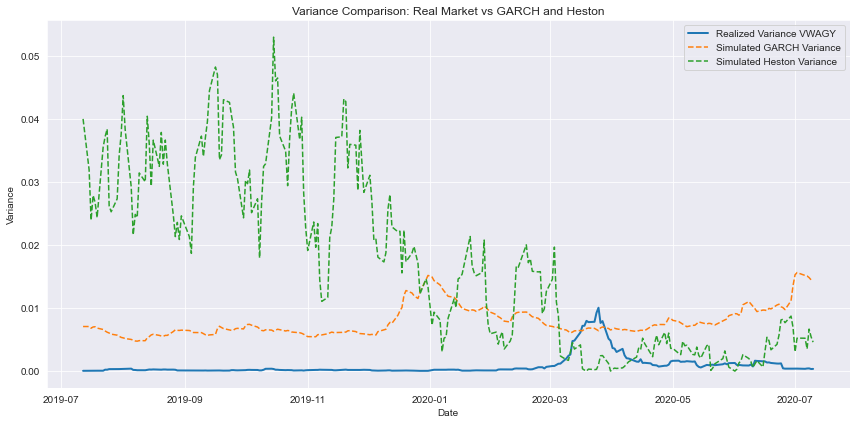

In [1107]:
# Do it for another ticker
ticker = "VWAGY"
data = yf.download(ticker, period = period_var, interval = interval_var)
data = data.dropna()

# log returns and realized variance
data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
data['realized_variance'] = data['log_return'].rolling(window=10).var()  # 10-day rolling variance

data = data.dropna()

# Trim real data and simulated paths to same length
data_trimmed = data.iloc[:n_sim_steps]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(data_trimmed.index, data_trimmed['realized_variance'], label=f'Realized Variance {ticker}', linewidth=2)
plt.plot(data_trimmed.index, garch_trimmed, label='Simulated GARCH Variance', linestyle='--')
plt.plot(data_trimmed.index, heston_trimmed, label='Simulated Heston Variance', linestyle='--')
plt.title("Variance Comparison: Real Market vs GARCH and Heston")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Conclusion from these experiments, was that the GARCH model may be more appropriate for emulating the variability compared to the Heston model. It is worth noting that since the introduction of the GARCH model, there has been a great number of variants proposed, since its introduction in the 1980s.